# Sommelier Inteligente App

## Visão geral e objetivos

Uma aplicação baseada em aprendizado de máquina que reconhece automaticamente um determinado tipo de vinho 
considerando os conjunto de dados do repositório [Wine Dataset da UCI](https://archive.ics.uci.edu/ml/datasets/wine)

# Passo 1. Setup do projeto

In [49]:
import joblib
import os
import urllib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

print('Matplot version : {}'.format(matplotlib.__version__))
print('Numpy version : {}'.format(np.__version__))
print('Pandas version : {}'.format(pd.__version__))
print('Sklearn version : {}'.format(sklearn.__version__))

WINE_ROOT = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/'
WINE_URL  = WINE_ROOT + 'wine.data'

DATA_PATH = os.path.join('..', 'data', 'raw')
DATA_FILE = 'wine.csv'
WINE_DATA = os.path.join(DATA_PATH, DATA_FILE)

DEPLOY_PATH = os.path.join('..', '', 'model')
DEPLOY_FILE = 'finalized_model.sav'

Matplot version : 3.3.2
Numpy version : 1.19.2
Pandas version : 1.1.3
Sklearn version : 0.23.2


# Passo 2. Recuperação dos dados

In [30]:
def download_data(data_url, data_path, data_file):
    os.makedirs(data_path, exist_ok=True)
    local_path = os.path.join(data_path, data_file)
    urllib.request.urlretrieve(data_url, local_path)

In [31]:
download_data(WINE_URL, DATA_PATH, DATA_FILE)

In [32]:
def load_data(data_path, data_file):
    local_path = os.path.join(data_path, data_file)
    return pd.read_csv(local_path, header=None, names=['name', 'alcohol', 'malic_acid', 
                                                        'ash', 'alcalinity_of_ash', 
                                                        'magnesium', 'total_phenols',
                                                        'flavanoids', 'nonflavanoid_phenols',
                                                        'proanthocyanins', 'color_intensity',
                                                        'hue', 'OD280/OD315_of_diluted_wines',
                                                        'proline'])
    

In [33]:
wine_data = load_data(DATA_PATH, DATA_FILE)

# Passo 3. Análise Exploratória de Dados

In [34]:
wine_data.head()

,name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [35]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   name                          178 non-null    int64  
 1   alcohol                       178 non-null    float64
 2   malic_acid                    178 non-null    float64
 3   ash                           178 non-null    float64
 4   alcalinity_of_ash             178 non-null    float64
 5   magnesium                     178 non-null    int64  
 6   total_phenols                 178 non-null    float64
 7   flavanoids                    178 non-null    float64
 8   nonflavanoid_phenols          178 non-null    float64
 9   proanthocyanins               178 non-null    float64
 10  color_intensity               178 non-null    float64
 11  hue                           178 non-null    float64
 12  OD280/OD315_of_diluted_wines  178 non-null    float64
 13  proli

In [36]:
wine_data.describe()

,name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [37]:
wine_data.isnull().sum()

name                            0
alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
OD280/OD315_of_diluted_wines    0
proline                         0
dtype: int64

In [38]:
wine_data['name'].value_counts()

2    71
1    59
3    48
Name: name, dtype: int64

## Correlação e distribuição

In [39]:
X = wine_data[['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols',
'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity',
'hue', 'OD280/OD315_of_diluted_wines', 'proline']]

y = wine_data['name']

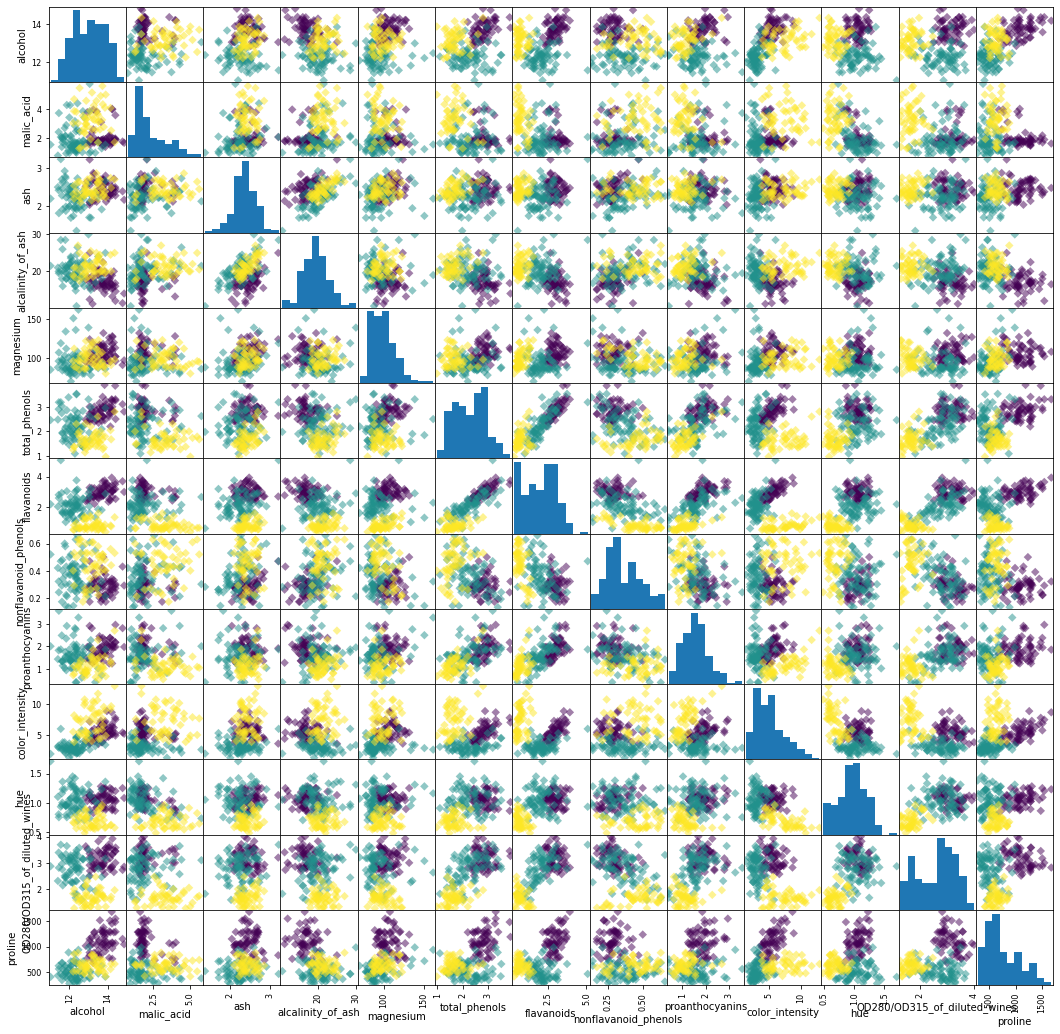

In [41]:
cores = y.astype('category').cat.codes
_ = pd.plotting.scatter_matrix(X, c=cores, figsize=[18, 18], marker='D')

# Passo 4: Treinamento do Modelo

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=42)

In [43]:
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy  = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i]  = knn.score(X_test, y_test)

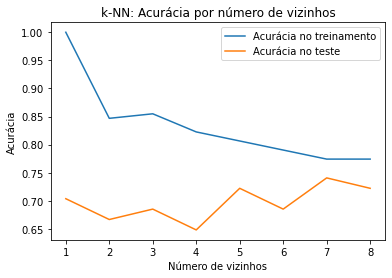

In [44]:
plt.title('k-NN: Acurácia por número de vizinhos')
plt.plot(neighbors, train_accuracy, label='Acurácia no treinamento')
plt.plot(neighbors, test_accuracy, label='Acurácia no teste')
plt.legend()
plt.xlabel('Número de vizinhos')
plt.ylabel('Acurácia')
plt.show()

In [45]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

# Passo 5: Testar o modelo

In [46]:
predicoes = model.predict(X_test)
print('Predições: {}'.format(predicoes))
[['1']][0]

Predições: [1 2 1 1 1 1 2 2 2 3 2 3 2 2 1 3 2 1 1 3 2 1 3 2 3 3 1 3 1 3 3 2 3 2 3 3 2
 3 3 3 2 1 1 1 1 2 2 1 3 1 2 2 3 1]


['1']

In [47]:
acuracia = model.score(X_test, y_test)
print("Acurácia do model: {}".format(acuracia))

Acurácia do model: 0.7222222222222222


# Passo 6. Deploy do modelo

In [50]:
local_path = os.path.join(DEPLOY_PATH, DEPLOY_FILE)
joblib.dump(model, local_path)

['..\\model\\finalized_model.sav']